**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Production economy and CO2 taxation](#toc1_)    
- 2. [Problem 2: Career choice model](#toc2_)    
- 3. [Problem 3: Barycentric interpolation](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
# Write your code here
import numpy as np
import scipy
from scipy.stats import norm
from types import SimpleNamespace
import matplotlib.pyplot as plt
from Examproject import *
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

%load_ext autoreload
%autoreload 2

## 1. <a id='toc1_'></a>[Problem 1: Production economy and CO2 taxation](#toc0_)

Consider a production economy with two firms indexed by $j \in \{1,2\}$. Each produce its own good. They solve

$$
\begin{align*}
\max_{y_{j}}\pi_{j}&=p_{j}y_{j}-w_{j}\ell_{j}\\\text{s.t.}\;&y_{j}=A\ell_{j}^{\gamma}.
\end{align*}
$$

Optimal firm behavior is

$$
\begin{align*}
\ell_{j}^{\star}(w,p_{j})&=\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}} \\
y_{j}^{\star}(w,p_{j})&=A\left(\ell_{j}^{\star}(w,p_{j})\right)^{\gamma}
\end{align*}
$$

The implied profits are

$$
\pi_{j}^*(w,p_{j})=\frac{1-\gamma}{\gamma}w\cdot\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}}
$$

A single consumer supplies labor, and consumes the goods the firms produce. She also recieves the implied profits of the firm.<br>
She solves:

$$
\begin{align*}
U(p_1,p_2,w,\tau,T) = \max_{c_{1},c_{2},\ell} & \log(c_{1}^{\alpha}c_{2}^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} \\
\text{s.t.}\,\,\,&p_{1}c_{1}+(p_{2}+\tau)c_{2}=w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})
\end{align*}
$$

where $\tau$ is a tax and $T$ is lump-sum transfer. <br>
For a given $\ell$, it can be shown that optimal behavior is

$$
\begin{align*}
c_{1}(\ell)&=\alpha\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{1}} \\
c_{2}(\ell)&=(1-\alpha)\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{2}+\tau} \\
\end{align*}
$$
Such that optimal behavior is:
$$
\ell^* = \underset{\ell}{\arg\max} \log(\left(c_{1}(\ell)\right)^{\alpha}\cdot \left(c_{2}(\ell)\right)^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} 
$$
With optimal consumption:
$$
\begin{align*}
c_1^*=c_{1}(\ell^*) \\
c_2^*=c_{2}(\ell^*)\\
\end{align*}
$$


The government chooses $\tau$ and balances its budget so $T=\tau c_2^*$. We initially set $\tau,T=0$.

Market clearing requires:

1. Labor market: $\ell^* = \ell_1^* + \ell_2^*$
1. Good market 1: $c_1^* = y_1^*$
1. Good market 2: $c_2^* = y_2^*$


**Question 1:** Check market clearing conditions for $p_1$ in `linspace(0.1,2.0,10)` and $p_2$ in `linspace(0.1,2.0,10)`. We choose $w=1$ as numeraire.

In [2]:
production = ProductionEconomy()

In [3]:
for i in np.linspace(0.1,2.0,10) :
    for j in np.linspace(0.1,2.0,10) :
        p1 = i  ;  p2 = j

        labor_mkt_clearing, good1_mkt_clearing, good2_mkt_clearing = production.check_market_clearing(p1,p2)
    
        # Print results
        # print(f'p1 = {p1:.3f} --> p2 = {p2:.3f} --> Labor market: {labor_mkt_clearing:.3f} --> Good market 1: {good1_mkt_clearing:.3f} --> Good market 2: {good2_mkt_clearing:.3f}')

**Question 2:** Find the equilibrium prices $p_1$ and $p_2$.<br>
*Hint: you can use Walras' law to only check 2 of the market clearings*

In [4]:
# Initial guess for equilibrium prices
initial_guess = [1,1]

# Compute the market equilibrium prices
p1_eq, p2_eq = production.compute_equilibrium(initial_guess)

# Compute the market clearing conditions with the equilibrium prices 
labor_mkt_clearing, good1_mkt_clearing, good2_mkt_clearing = production.check_market_clearing(p1_eq,p2_eq)

print(f'The market clearing prices are p1 = {p1_eq:.3f} and p2 = {p2_eq:.3f}')
print(f'Market clearing condition for good market 1: {good1_mkt_clearing:.3f}')
print(f'Market clearing condition for good market 2: {good2_mkt_clearing:.3f}')
print(f'Market clearing condition for labor market: {labor_mkt_clearing:.3f}')

The market clearing prices are p1 = 0.976 and p2 = 1.491
Market clearing condition for good market 1: 0.000
Market clearing condition for good market 2: 0.000
Market clearing condition for labor market: 0.000


Assume the government care about the social welfare function:

$$
SWF = U - \kappa y_2^*
$$

Here $\kappa$ measures the social cost of carbon emitted by the production of $y_2$ in equilibrium.

**Question 3:** What values of $\tau$ and (implied) $T$ should the government choose to maximize $SWF$?

In [5]:
# Write your answer here

## 2. <a id='toc2_'></a>[Problem 2: Career choice model](#toc0_)

Consider a graduate $i$ making a choice between entering $J$ different career tracks. <br>
Entering career $j$ yields utility $u^k_{ij}$. This value is unknown to the graduate ex ante, but will ex post be: <br>
$$
    u_{i,j}^k = v_{j} + \epsilon_{i,j}^k
$$

They know that $\epsilon^k_{i,j}\sim \mathcal{N}(0,\sigma^2)$, but they do not observe $\epsilon^k_{i,j}$ before making their career choice. <br>

Consider the concrete case of $J=3$ with:
$$
\begin{align*}
    v_{1} &= 1 \\
    v_{2} &= 2 \\
    v_{3} &= 3
\end{align*}
$$

If the graduates know the values of $v_j$ and the distribution of $\epsilon_{i,j}^k$, they can calculate the expected utility of each career track using simulation: <br>
$$
    \mathbb{E}\left[ u^k_{i,j}\vert v_j \right] \approx v_j + \frac{1}{K}\sum_{k=1}^K \epsilon_{i,j}^k
$$

In [13]:
par = SimpleNamespace() 
par.J = 3 
par.N = 10
par.K = 10000

 # Først til opgave 2
par.sigma = 2

par.v = np.array([1,2,3])
#  Først til opgave 2

# Question 2
par.F = np.arange(1,par.N+1)

# Question 3
par.c = 1

**Question 1:** Simulate and calculate expected utility and the average realised utility for $K=10000$ draws, for each career choice $j$.


In [49]:
career = Career()

In [48]:
exp_util, avg_real_util = career.expected_career_util()

print(f'The expected utility for v1 = {exp_util[0]:.3f}, v2 = {exp_util[1]:.3f} and v3 = {exp_util[2]:.3f}')
print(f'The average realized utility for v1 = {avg_real_util[0]:.3f}, v2 = {avg_real_util[1]:.3f} and v3 = {avg_real_util[2]:.3f}')

The expected utility for v1 = 0.959, v2 = 2.004 and v3 = 3.024
The average realized utility for v1 = 0.959, v2 = 2.004 and v3 = 3.024


Now consider a new scenario: Imagine that the graduate does not know $v_j$. The *only* prior information they have on the value of each job, comes from their $F_{i}$ friends that work in each career $j$. After talking with them, they know the average utility of their friends (which includes their friends' noise term), giving them the prior expecation: <br>
$$
\tilde{u}^k_{i,j}\left( F_{i}\right) = \frac{1}{F_{i}}\sum_{f=1}^{F_{i}} \left(v_{j} + \epsilon^k_{f,j}\right), \; \epsilon^k_{f,j}\sim \mathcal{N}(0,\sigma^2)
$$
For ease of notation consider that each graduate have $F_{i}=i$ friends in each career. <br>

For $K$ times do the following: <br>
1. For each person $i$ draw $J\cdot F_i$ values of $\epsilon_{f,j}^{k}$, and calculate the prior expected utility of each career track, $\tilde{u}^k_{i,j}\left( F_{i}\right)$. <br>
Also draw their own $J$ noise terms, $\epsilon_{i,j}^k$
1. Each person $i$ chooses the career track with the highest expected utility: $$j_i^{k*}= \arg\max_{j\in{1,2\dots,J}}\left\{ \tilde{u}^k_{i,j}\left( F_{i}\right)\right\} $$
1. Store the chosen careers: $j_i^{k*}$, the prior expectation of the value of their chosen career: $\tilde{u}^k_{i,j=j_i^{k*}}\left( F_{i}\right)$, and the realized value of their chosen career track: $u^k_{i,j=j_i^{k*}}=v_{j=j_i^{k*}}+\epsilon_{i,j=j_i^{k*}}^k$.

Chosen values will be: <br>
$i\in\left\{1,2\dots,N\right\}, N=10$ <br>
$F_i = i$<br>
So there are 10 graduates. The first has 1 friend in each career, the second has 2 friends, ... the tenth has 10 friends.

**Question 2:** Simulate and visualize: For each type of graduate, $i$, the share of graduates choosing each career, the average subjective expected utility of the graduates, and the average ex post realized utility given their choice. <br>
That is, calculate and visualize: <br>
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \mathbb{I}\left\{ j=j_i^{k*} \right\}  \;\forall j\in\left\{1,2,\dots,J\right\}
\end{align*}
$$
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \tilde{u}^k_{ij=j_i^{k*}}\left( F_{i}\right)
\end{align*}
$$
And 
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} u^k_{ij=j_i^{k*}} 
\end{align*}
$$
For each graduate $i$.

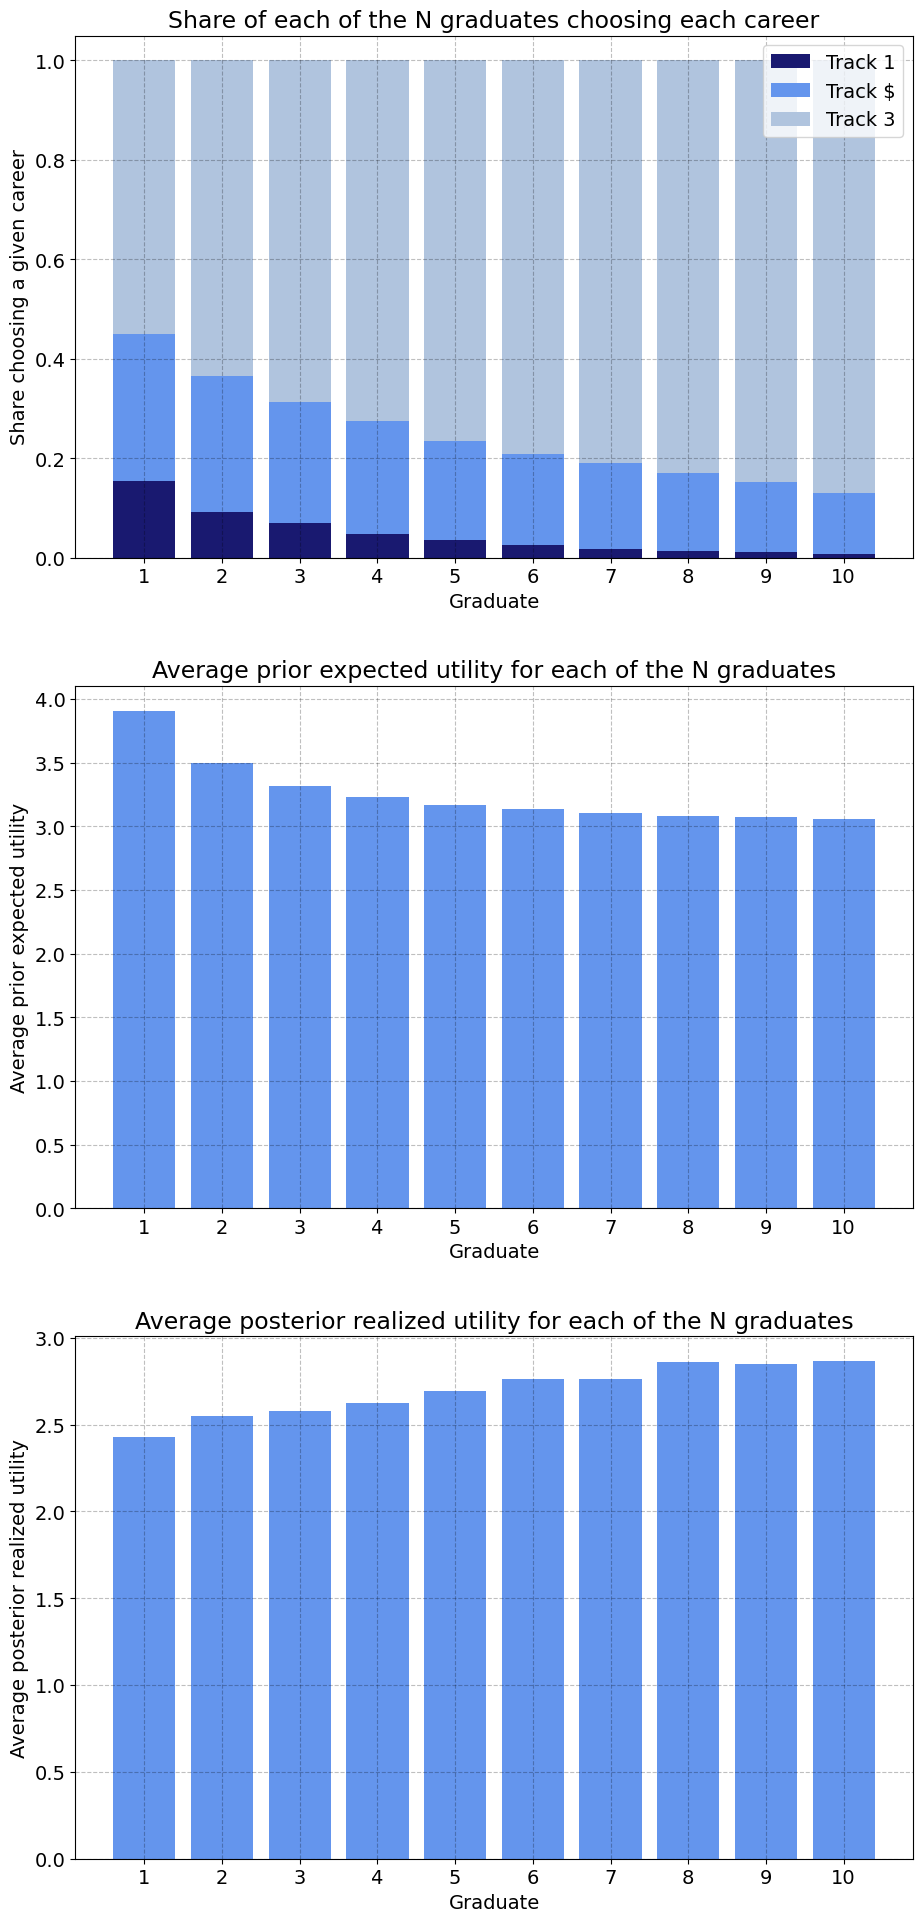

In [50]:
track_share = np.zeros([par.N,par.J])
avg_prior = np.zeros(par.N)
avg_post = np.zeros(par.N)

for i in par.F :

    # Simulate the career path of graduate i
    simulation = sim_track, sim_prior, sim_post = career.simulate_career(i)

    # Compute results
    track_share_i, avg_prior_i, avg_post_i = career.compute_results(simulation)
    
    track_share[i-1] = track_share_i
    avg_prior[i-1] = avg_prior_i
    avg_post[i-1] = avg_post_i

simulated_results = track_share, avg_prior, avg_post
# print(f'For i = {i}: Share track 1 = {track_share[0]:.3f}, Share track 2 = {track_share[1]:.3f}, Share track 3 = {track_share[2]:.3f}, average subjective expected utility is {avg_sub_i[i-1]:.3f} and average ex post realized utility is {avg_ex_post_i[i-1]:.3f}') 

career.plot_results(simulated_results)


After a year of working in their career, the graduates learn $u^k_{ij}$ for their chosen job $j_i^{k*}$ perfectly. <br>
The can switch to one of the two remaining careers, for which they have the same prior as before, but it will now include a switching cost of $c$ which is known.
Their new priors can be written as: 
$$
\tilde{u}^{k,2}_{ij}\left( F_{i}\right) = \begin{cases}
            \tilde{u}^k_{ij}\left( F_{i}\right)-c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

We will set $c=1$.

Their realized utility will be: <br>
$$
u^{k,2}_{ij}= \begin{cases}
            u_{ij}^k -c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

**Question 3:** Following the same approach as in question 2, find the new optimal career choice for each $i$, $k$. Then for each $i$, calculate the average subjective expected utility from their new optimal career choice, and the ex post realized utility of that career. Also, for each $i$, calculate the share of graduates that chooses to switch careers, conditional on which career they chose in the first year. <br>

In [80]:
# CHANGE TO PAR.C INSTEAD OF 1
# MAKE FIGURES OR SHOW RESULTS IN SOME WAY!

# We set the seed as 2000
np.random.seed(2000)

def career_change_i(i) :

    chosen_j, _, _, prior_exp_util, realized_util  = career_i(i) 
    
    # For all but the chosen career deduct c from the realized utility
    for q in range(par.J) :
        if q + 1 == chosen_j :
            continue
        else :
            realized_util[q] = realized_util[q] - 1
            prior_exp_util[q] = prior_exp_util[q] - 1

    # Evaluate the vector of realized utility with deduction. Change career path if another career provides higher utility.
    new_career = np.argmax(realized_util) + 1

    # The updated prior and realized utility from either channging or not changing career paths.
    new_prior = np.max(prior_exp_util) 
    new_realized = np.max(realized_util)

    # Indicator to show if they changed career paths.
    if new_career != chosen_j :
        change_career = 1
    else :
        change_career = 0

    return chosen_j, new_career, change_career, new_prior, new_realized

def simulation_change_i(i) :
    
    old_career_i = np.zeros(par.K)
    new_optimal_i = np.zeros(par.K)
    new_prior_i = np.zeros(par.K)
    new_realized_i = np.zeros(par.K)

    change_track = np.zeros(par.J)
    original_track = np.zeros(par.J)

    for k in range(par.K) :
        chosen_j, new_career, change_career, new_prior, new_realized = career_change_i(i)

        old_career_i[k] = chosen_j
        new_optimal_i[k] = new_career
        new_prior_i[k] = new_prior
        new_realized_i[k] = new_realized

        # Next we compute the share that switches job conditioned on which job they originally took
        for b in range(par.J) :
            if chosen_j == b + 1 and change_career == 1 :
                change_track[b] = change_track[b] + 1


    # Number of simulations in which career paths 1, 2 or 3 where chosen
    for b in range(par.J) :
        original_track[b] = np.count_nonzero(old_career_i == b + 1, axis = 0)

    new_avg_sub_exp_util = np.mean(new_prior_i)
    new_avg_ex_post_real = np.mean(new_realized_i)
    
    share_condition = change_track / original_track

    return new_avg_sub_exp_util, new_avg_ex_post_real, share_condition

new_avg_sub_i = np.zeros(par.N)
new_avg_ex_post_i = np.zeros(par.N)
share_condition_i = np.zeros([par.N,par.J])


for i in par.F :

    new_avg_sub_exp_util, new_avg_ex_post_real, share_condition = simulation_change_i(i)
    
    new_avg_sub_i[i-1] = new_avg_sub_exp_util
    new_avg_ex_post_i[i-1] = new_avg_ex_post_real
    share_condition_i[i-1] = share_condition

# Shit has been calculated!!!

print(new_avg_ex_post_i)


[3.39346089 3.44840178 3.40655756 3.42398982 3.43182132 3.44838042
 3.45254037 3.5153557  3.48382636 3.48098822]


In [79]:
change_share = np.zeros([par.N,par.J])
avg_prior = np.zeros(par.N)
avg_post = np.zeros(par.N)

for i in par.F :

    # Simulate the career path of graduate i
    simulation = sim_prev_track, sim_track, sim_prior, sim_post, change_each_track = career.simulate_career(i, allow_change = True)

    # Compute results
    change_share_i, avg_prior_i, avg_post_i = career.compute_results(simulation, allow_change = True)
    
    change_share[i-1] = change_share_i
    avg_prior[i-1] = avg_prior_i
    avg_post[i-1] = avg_post_i

print(avg_post)

[3.38331954 3.42421101 3.42332759 3.45907755 3.430366   3.4214247
 3.45740399 3.45995745 3.49306124 3.52101783]


## 3. <a id='toc3_'></a>[Problem 3: Barycentric interpolation](#toc0_)

**Problem:** We have a set of random points in the unit square,

$$
\mathcal{X} = \{(x_1,x_2)\,|\,x_1\sim\mathcal{U}(0,1),x_2\sim\mathcal{U}(0,1)\}.
$$

For these points, we know the value of some function $f(x_1,x_2)$,

$$
\mathcal{F} = \{f(x_1,x_2) \,|\, (x_1,x_2) \in \mathcal{X}\}.
$$

Now we want to approximate the value $f(y_1,y_2)$ for some  $y=(y_1,y_2)$, where $y_1\sim\mathcal{U}(0,1)$ and $y_2\sim\mathcal{U}(0,1)$.

**Building block I**

For an arbitrary triangle $ABC$ and a point $y$, define the so-called barycentric coordinates as:

$$
\begin{align*}
  r^{ABC}_1 &= \frac{(B_2-C_2)(y_1-C_1) + (C_1-B_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_2 &= \frac{(C_2-A_2)(y_1-C_1) + (A_1-C_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_3 &= 1 - r_1 - r_2.
\end{align*}
$$

If $r^{ABC}_1 \in [0,1]$, $r^{ABC}_2 \in [0,1]$, and $r^{ABC}_3 \in [0,1]$, then the point is inside the triangle.

We always have $y = r^{ABC}_1 A + r^{ABC}_2 B + r^{ABC}_3 C$.

**Building block II**

Define the following points:

$$
\begin{align*}
A&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}>y_{2}\\
B&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}<y_{2}\\
C&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}<y_{2}\\
D&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}>y_{2}.
\end{align*}
$$

**Algorithm:**

1. Compute $A$, $B$, $C$, and $D$. If not possible return `NaN`.
1. If $y$ is inside the triangle $ABC$ return $r^{ABC}_1 f(A) + r^{ABC}_2 f(B) + r^{ABC}_3 f(C)$.
1. If $y$ is inside the triangle $CDA$ return $r^{CDA}_1 f(C) + r^{CDA}_2 f(D) + r^{CDA}_3 f(A)$.
1. Return `NaN`.



**Sample:**

In [13]:
rng = np.random.default_rng(2024)

X = rng.uniform(size=(50,2))
y = rng.uniform(size=(2,))
print(y)

[0.20901926 0.37774759]


**Questions 1:** Find $A$, $B$, $C$ and $D$. Illustrate these together with $X$, $y$ and the triangles $ABC$ and $CDA$.

Point A = (0.261,0.436)
Point B = (0.213,0.274)
Point C = (0.101,0.280)
Point D = (0.206,0.443)


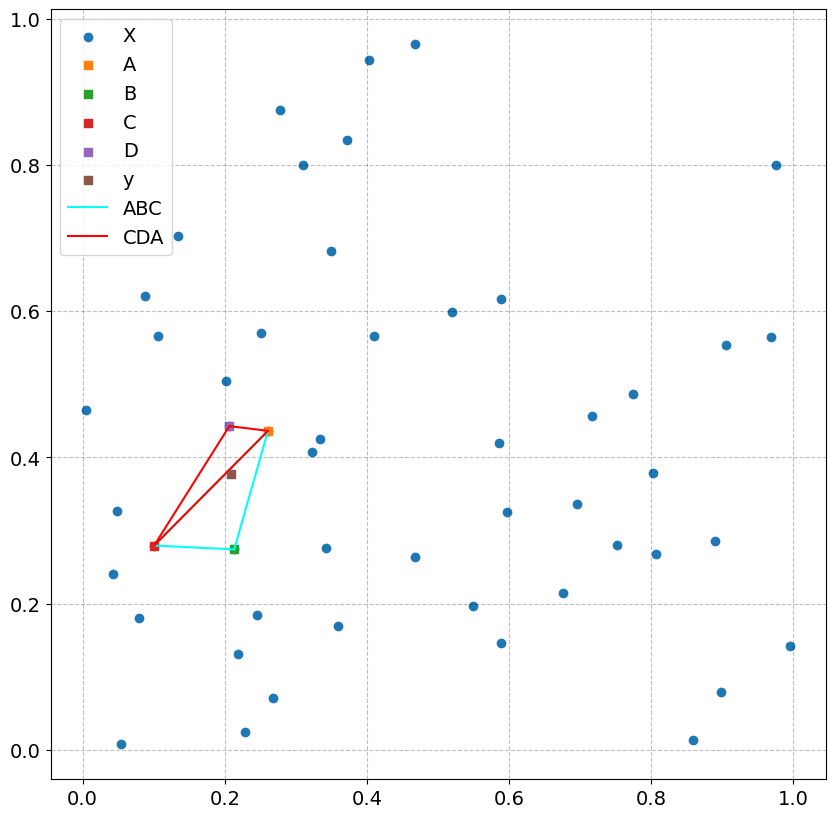

In [14]:
def func_to_min(x1,x2,y1,y2) :
    composite = (x1 - y1) ** 2 + (x2 - y2) ** 2
    return composite ** (1/2) 

# Define 4 points of (0,0)
points = np.zeros([4,2])

# Define the constraints
def constraints(x1,x2,y1,y2) :
    constraints = np.array([x1 > y1 and x2 > y2,x1 > y1 and x2 < y2,x1 < y1 and x2 < y2,x1 < y1 and x2 > y2])
    return constraints

# Simple minimizer with a for loop
def minimizer(points,y) :

    y1,y2 = y

    for point,cons in zip(points,[0,1,2,3]) :

        value = np.inf

        for x1,x2 in X :

            # Calculate all 4 constraints
            constraint = constraints(x1,x2,y1,y2)

            # Evaluate the relevant constraint and return the function value if the constraint is true
            if constraint[cons] == True :
                temp_val = func_to_min(x1,x2,y1,y2)
        
            # If not true return NaN
            else :
                temp_val = np.NaN

            # If the calculated function value is the smallest yet update the variable value and the point
            if temp_val < value :
                value = temp_val
                point = [x1,x2]

        points[cons] = point

    A = points[0]
    B = points[1]
    C = points[2]
    D = points[3]

    return A,B,C,D


A,B,C,D = minimizer(points,y)

# Print A, B, C and D
print(f'Point A = ({A[0]:.3f},{A[1]:.3f})')
print(f'Point B = ({B[0]:.3f},{B[1]:.3f})')
print(f'Point C = ({C[0]:.3f},{C[1]:.3f})')
print(f'Point D = ({D[0]:.3f},{D[1]:.3f})')


fig, ax = plt.subplots(1,1, figsize = (10,10))

ax.scatter(X[:,0],X[:,1], label = 'X')
ax.scatter(A[0],A[1],marker = 's', label = 'A')
ax.scatter(B[0],B[1],marker = 's', label = 'B')
ax.scatter(C[0],C[1],marker = 's', label = 'C')
ax.scatter(D[0],D[1],marker = 's', label = 'D')
ax.scatter(y[0],y[1],marker = 's', label = 'y')

# if A is not None and B is not None and C is not None :
ax.plot( [ A[0], B[0] ] , [ A[1], B[1] ], color = 'cyan', label = 'ABC' )
ax.plot( [ B[0], C[0] ] , [ B[1], C[1] ], color = 'cyan' )
ax.plot( [ A[0], C[0] ] , [ A[1], C[1] ], color = 'cyan' )

ax.plot( [ C[0], D[0] ] , [ C[1], D[1] ], color = 'red', label = 'CDA' )
ax.plot( [ D[0], A[0] ] , [ D[1], A[1] ], color = 'red' )
ax.plot( [ A[0], C[0] ] , [ A[1], C[1] ], color = 'red' )

ax.legend() ;



**Question 2:** Compute the barycentric coordinates of the point $y$ with respect to the triangles $ABC$ and $CDA$. Which triangle is $y$ located inside?

In [15]:
def r1(A,B,C,y) :
    y1,y2 = y
    num = (B[1] - C[1]) * (y1 - C[0]) + (C[0] - B[0]) * (y2 - C[1])
    denum = (B[1] - C[1]) * (A[0] - C[0]) + (C[0] - B[0]) * (A[1] - C[1])
    return num / denum

def r2(A,B,C,y) :
    y1,y2 = y
    num = (C[1] - A[1]) * (y1 - C[0]) + (A[0] - C[0]) * (y2 - C[1])
    denum = (B[1] - C[1]) * (A[0] - C[0]) + (C[0] - B[0]) * (A[1] - C[1])
    return num / denum

def r3(r1,r2) :
    return 1 - r1 - r2

r1_ABC = r1(A,B,C,y)
r2_ABC = r2(A,B,C,y)
r3_ABC = r3(r1_ABC,r2_ABC)

r1_CDA = r1(C,D,A,y)
r2_CDA = r2(C,D,A,y)
r3_CDA = r3(r1_CDA,r2_CDA)

y_ABC = r1_ABC * A + r2_ABC * B + r3_ABC * C
y_CDA = r1_CDA * C + r2_CDA * D + r3_CDA * A

print(f'Barycentric coordinates for triangle ABC: ({r1_ABC:.3f},{r2_ABC:.3f},{r3_ABC:.3f})')
print(f'Barycentric coordinates for triangle CDA: ({r1_CDA:.3f},{r2_CDA:.3f},{r3_CDA:.3f})')
print(f'The point y is therefore located inside the triangle ABC')

print()

print(f'We also check the stated identity for both triangle ABC and CDA')
print(f'The point y is ({y[0]:.3f},{y[1]:.3f}). We compute y for triangle ABC as ({y_ABC[0]:.3f},{y_ABC[1]:.3f}) and y for triangle CDA as ({y_CDA[0]:.3f},{y_CDA[1]:.3f}).')


Barycentric coordinates for triangle ABC: (0.629,0.069,0.302)
Barycentric coordinates for triangle CDA: (0.368,-0.134,0.766)
The point y is therefore located inside the triangle ABC

We also check the stated identity for both triangle ABC and CDA
The point y is (0.209,0.378). We compute y for triangle ABC as (0.209,0.378) and y for triangle CDA as (0.209,0.378).


Now consider the function:
$$
f(x_1,x_2) = x_1 \cdot x_2
$$

In [16]:
f = lambda x: x[0]*x[1]
F = np.array([f(x) for x in X])

**Question 3:** Compute the approximation of $f(y)$ using the full algorithm. Compare with the true value.

In [17]:
# We employ the full algorithm

# 1. Compute A, B, C and D. If not possible return NaN.
A,B,C,D = minimizer(points,y)

# 2. If y is inside the triangle ABC return ...
if 0 <= r1(A,B,C,y) <= 1 and 0 <= r2(A,B,C,y) <= 1 and 0 <= r3(r1(A,B,C,y),r2(A,B,C,y)) <= 1 :
    f_approx = r1(A,B,C,y) * f(A) + r2(A,B,C,y) * f(B) + r3(r1(A,B,C,y),r2(A,B,C,y)) * f(C)

# 3. If y is inside the triangle CDA return ...
elif 0 <= r1(C,D,A,y) <= 1 and 0 <= r2(C,D,A,y) <= 1 and 0 <= r3(r1(C,D,A,y),r2(C,D,A,y)) <= 1 :
    f_approx = r1(C,D,A,y) * f(C) + r2(C,D,A,y) * f(D) + r3(r1(C,D,A,y),r2(C,D,A,y)) * f(A)

# 4. Return NaN.
else :
    f_approx = np.NaN

true_val = f(y) ; 

print(f'The true value of f(y) is {true_val:.3f}')
print(f'The approximation of the value f(y) is {f_approx:.3f}')

The true value of f(y) is 0.079
The approximation of the value f(y) is 0.084


**Question 4:** Repeat question 3 for all points in the set $Y$.

In [18]:
Y = [(0.2,0.2),(0.8,0.2),(0.8,0.8),(0.8,0.2),(0.5,0.5)]

# We redefine the list as a numpy array
Y_np = np.array(Y)

In [19]:
for y in Y_np :

    # 1. Compute A, B, C and D. If not possible return NaN.
    A,B,C,D = minimizer(points,y)

    # 2. If y is inside the triangle ABC return ...
    if 0 <= r1(A,B,C,y) <= 1 and 0 <= r2(A,B,C,y) <= 1 and 0 <= r3(r1(A,B,C,y),r2(A,B,C,y)) <= 1 :
        f_approx = r1(A,B,C,y) * f(A) + r2(A,B,C,y) * f(B) + r3(r1(A,B,C,y),r2(A,B,C,y)) * f(C)

    # 3. If y is inside the triangle CDA return ...
    elif 0 <= r1(C,D,A,y) <= 1 and 0 <= r2(C,D,A,y) <= 1 and 0 <= r3(r1(C,D,A,y),r2(C,D,A,y)) <= 1 :
        f_approx = r1(C,D,A,y) * f(C) + r2(C,D,A,y) * f(D) + r3(r1(C,D,A,y),r2(C,D,A,y)) * f(A)

    # 4. Return NaN.
    else :
        f_approx = np.NaN

    true_val = f(y) ; 

    print(f'For (y1,y2) = ({y[0]},{y[1]}) --> f({y[0]},{y[1]}) = {true_val:.3f} --> approximated function value is {f_approx:.3f}')

For (y1,y2) = (0.2,0.2) --> f(0.2,0.2) = 0.040 --> approximated function value is 0.040
For (y1,y2) = (0.8,0.2) --> f(0.8,0.2) = 0.160 --> approximated function value is 0.159
For (y1,y2) = (0.8,0.8) --> f(0.8,0.8) = 0.640 --> approximated function value is nan
For (y1,y2) = (0.8,0.2) --> f(0.8,0.2) = 0.160 --> approximated function value is 0.159
For (y1,y2) = (0.5,0.5) --> f(0.5,0.5) = 0.250 --> approximated function value is 0.251
